Overall Audio Duration Statistics:
count    3998.000000
mean       10.028423
std         0.151353
min         6.232687
25%        10.011188
50%        10.041094
75%        10.044000
max        11.680500
Name: duration_sec, dtype: float64

Grouped Duration Statistics:
  language    category  count        min        max       mean       std
0  Chinese    tampered   1000   9.732625  10.630250  10.037715  0.030254
1  Chinese  untampered   1000  10.008000  10.044000  10.035936  0.015017
2  English    tampered    998   6.232687  11.680500  10.016185  0.292859
3  English  untampered   1000   8.175000  10.095937  10.023833  0.067859


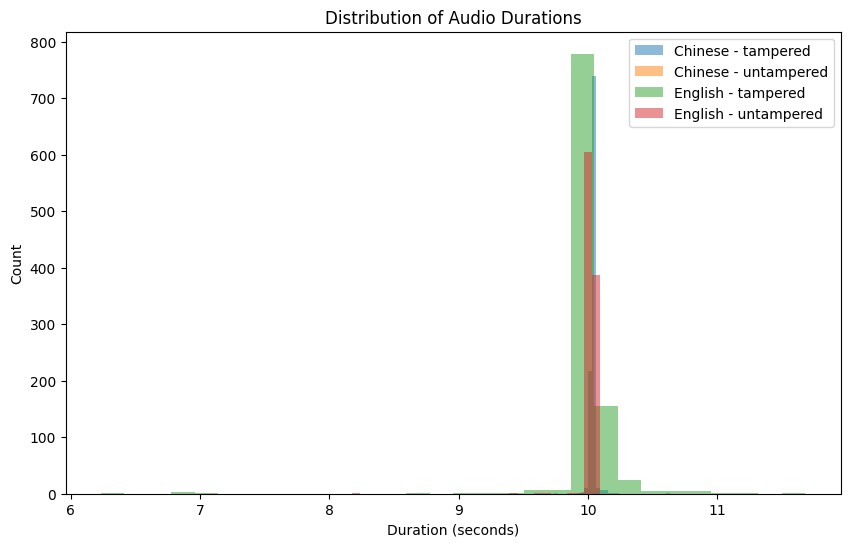

In [25]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define dataset directory (update to your path)
dataset_dir = "D:/Vs code/deepfake audio detection/CMFD-master"

languages = ['English', 'Chinese']
categories = ['tampered', 'untampered']

# Create a list to store results
results = []

# Iterate through all audio files in the dataset directory structure
for lang in languages:
    for category in categories:
        # Construct the folder path assuming structure: CMFD-masters -> language -> category -> category
        folder_path = os.path.join(dataset_dir, lang, category, category)
        if not os.path.isdir(folder_path):
            continue

        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                try:
                    y, sr = librosa.load(file_path, sr=16000)  # Load with 16 kHz sampling rate
                    duration = len(y) / sr
                    # You could add other stats like mean amplitude, energy, etc.
                    results.append({
                        'language': lang,
                        'category': category,
                        'filename': file,
                        'duration_sec': duration,
                        'num_samples': len(y)
                    })
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

# Convert the results into a DataFrame for analysis
df = pd.DataFrame(results)

# Print basic statistics
print("Overall Audio Duration Statistics:")
print(df['duration_sec'].describe())

# Group by language and category
grouped = df.groupby(['language', 'category'])['duration_sec']
stats = grouped.agg(['count', 'min', 'max', 'mean', 'std']).reset_index()
print("\nGrouped Duration Statistics:")
print(stats)

# Visualize distribution of durations
plt.figure(figsize=(10, 6))
for key, grp in df.groupby(['language', 'category']):
    plt.hist(grp['duration_sec'], bins=30, alpha=0.5, label=f"{key[0]} - {key[1]}")
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations')
plt.legend()
plt.show()


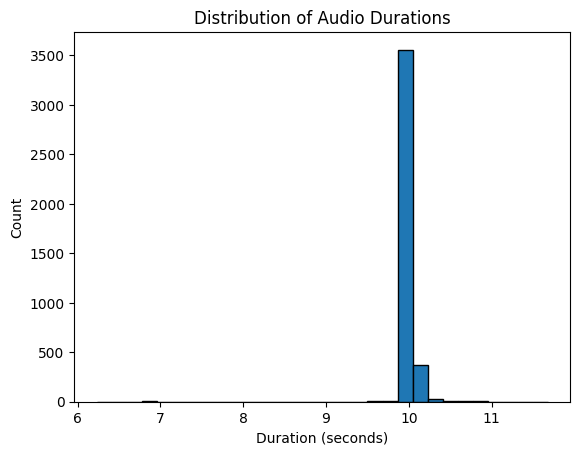

In [14]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Define dataset directory
dataset_dir = "D:/Vs code/deepfake audio detection/CMFD-master"

# Function to extract Mel-spectrogram
def extract_mel_spectrogram(file_path, n_mels=224, hop_length=512):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Define a fixed spectrogram shape (n_mels x time_frames)
fixed_shape = (224, 224)  # 128 Mel filters, 128 time frames

# Function to pad/truncate spectrograms to a fixed shape
def pad_or_truncate(spec, target_shape):
    """Ensure spectrogram has fixed dimensions"""
    current_shape = spec.shape
    padded_spec = np.zeros(target_shape)

    # Truncate if it's too long
    min_shape = (min(current_shape[0], target_shape[0]), min(current_shape[1], target_shape[1]))
    padded_spec[:min_shape[0], :min_shape[1]] = spec[:min_shape[0], :min_shape[1]]

    return padded_spec

# Process dataset with fixed shape spectrograms
X, y = [], []
languages = ['English', 'Chinese']
categories = {'tampered': 1, 'untampered': 0}

for lang in languages:
    for category, label in categories.items():
        folder_path = os.path.join(dataset_dir, lang, category, category)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                mel_spec = extract_mel_spectrogram(file_path)
                mel_spec = pad_or_truncate(mel_spec, fixed_shape)  # Fix shape
                X.append(mel_spec)
                y.append(label)

# Convert to numpy array
X = np.array(X)[..., np.newaxis]  # Add channel dimension for CNN input
y = np.array(y)
# # Check audio file durations
# durations = []
# for lang in languages:
#     for category in categories.keys():
#         folder_path = os.path.join(dataset_dir, lang, category, category)
#         for file in os.listdir(folder_path):
#             if file.endswith(".wav"):
#                 file_path = os.path.join(folder_path, file)
#                 audio, sr = librosa.load(file_path, sr=16000)  
#                 durations.append(len(audio) / sr)

# plt.hist(durations, bins=30, edgecolor='black')
# plt.xlabel('Duration (seconds)')
# plt.ylabel('Count')
# plt.title('Distribution of Audio Durations')
# plt.show()



In [15]:
print(X.shape,X[0].shape)
print(y.shape)

(3998, 224, 224, 1) (224, 224, 1)
(3998,)


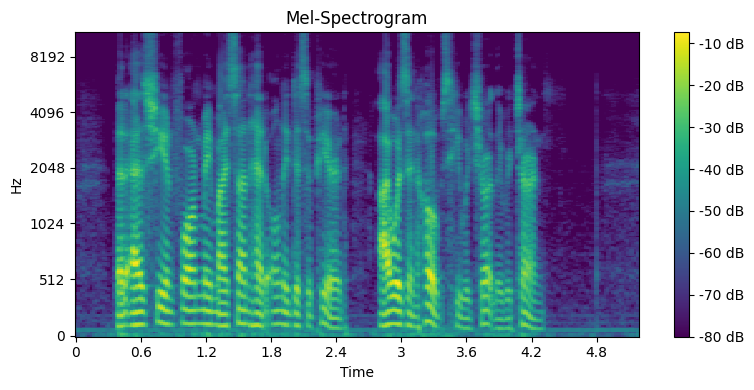

In [26]:
mel_spec = np.squeeze(X[3])

plt.figure(figsize=(8, 4))
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Resize images to fit VGG16 input size
# X_train_resized = np.repeat(tf.image.resize(X_train, (224, 224)).numpy(), 3, axis=-1)
# X_test_resized = np.repeat(tf.image.resize(X_test, (224, 224)).numpy(), 3, axis=-1)
X_train_resized = np.repeat(X_train, 3, axis=-1)
X_test_resized = np.repeat(X_test, 3, axis=-1)


In [23]:
# Load Pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 248s 10s/step - accuracy: 0.5134 - loss: 1.1172 - val_accuracy: 0.5375 - val_loss: 0.7147
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 235s 9s/step - accuracy: 0.5142 - loss: 0.9643 - val_accuracy: 0.5663 - val_loss: 0.6883
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 234s 9s/step - accuracy: 0.5417 - loss: 0.8778 - val_accuracy: 0.5938 - val_loss: 0.6714
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 235s 9s/step - accuracy: 0.5543 - loss: 0.8126 - val_accuracy: 0.6137 - val_loss: 0.6615
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 234s 9s/step - accuracy: 0.5593 - loss: 0.7800 - val_accuracy: 0.5863 - val_loss: 0.6557
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 234s 9s/step - accuracy: 0.5652 - loss: 0.7409 - val_accuracy: 0.6225 - val_loss: 0.6453
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 236s 10s/step - accuracy: 0.5873 - loss: 0.7154 - val_accuracy: 0.6250 - val_loss: 0.6422
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 241s 10s/step - accuracy: 0.6130 - loss: 0.6669 - val_accuracy: 0.6250 

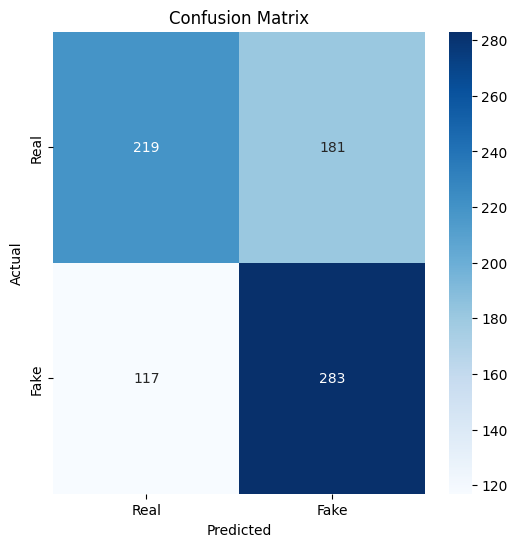

In [24]:
# Train Model
history = model.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=10, batch_size=128 )

# Evaluate
preds = model.predict(X_test_resized)
preds_binary = (preds > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, preds_binary))
print("AUC-ROC:", roc_auc_score(y_test, preds))

# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, preds_binary), annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [28]:
meta = "D:/Vs code/deepfake audio detection/release_in_the_wild/meta.csv"


Test data shape: (1000, 224, 224, 3)
Test labels shape: (1000,)
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
Test Accuracy: 0.523
Test AUC-ROC: 0.6181165964916744
Confusion Matrix:
 [[254 365]
 [112 269]]


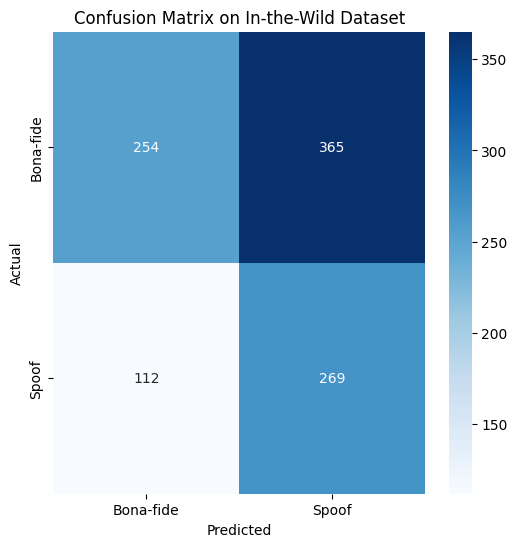

In [30]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns



def preprocess_spectrogram(file_path):
    """
    Given an audio file, extract its mel spectrogram, pad/truncate to fixed size,
    and convert it to a 3-channel image (for VGG input).
    """
    # Extract mel-spectrogram
    spec = extract_mel_spectrogram(file_path, n_mels=224, hop_length=512)
    # Pad/truncate so that time frames become 224 as well
    spec = pad_or_truncate(spec, target_shape=(224, 224))
    # Normalize spectrogram (optional: you can add further normalization if used during training)
    # Expand dims to add channel axis, then repeat to get 3 channels.
    spec = np.expand_dims(spec, axis=-1)  # (224, 224, 1)
    spec = np.repeat(spec, 3, axis=-1)      # (224, 224, 3)
    # Convert to float32 (if necessary)
    return spec.astype(np.float32)

# ---- Load metadata and prepare test data ----

# Path to the CSV metadata file for the In-the-Wild dataset.
csv_path = "D:/Vs code/deepfake audio detection/release_in_the_wild/meta.csv"  # Update this path

# Path to the audio files folder
audio_dir = "D:/Vs code/deepfake audio detection/release_in_the_wild"  # Update this path

# Load metadata
df = pd.read_csv(csv_path).sample(n=1000, random_state=42)

# Map labels to binary values
# 'spoof' -> 1 and 'bona-fide' -> 0
label_map = {'spoof': 1, 'bona-fide': 0}
df['binary_label'] = df['label'].map(label_map)

# Prepare lists to hold spectrograms and labels
X_test = []
y_test = []

durations = []
for lang in languages:
    for category in categories.keys():
        folder_path = os.path.join(dataset_dir, lang, category, category)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path, sr=16000)  
                durations.append(len(audio) / sr)

plt.hist(durations, bins=30, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations')
plt.show()

for index, row in df.iterrows():
    file_name = row['file']
    file_path = os.path.join(audio_dir, file_name)
    if os.path.exists(file_path):
        spec = preprocess_spectrogram(file_path)
        X_test.append(spec)
        y_test.append(row['binary_label'])
    else:
        print(f"File not found: {file_path}")

X_test = np.array(X_test)  # Shape should be (num_samples, 224, 224, 3)
y_test = np.array(y_test)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


# ---- Run inference on the test set ----
preds = model.predict(X_test)
preds_binary = (preds > 0.5).astype(int).flatten()

# ---- Evaluation Metrics ----
accuracy = accuracy_score(y_test, preds_binary)
auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds_binary)

print("Test Accuracy:", accuracy)
print("Test AUC-ROC:", auc)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bona-fide', 'Spoof'], 
            yticklabels=['Bona-fide', 'Spoof'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on In-the-Wild Dataset')
plt.show()
